In [9]:
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image, ImageOps
import math
from sklearn.model_selection import train_test_split
from collections import defaultdict

np.random.seed(123)

In [55]:
#data_root = 'data/train_1000_10'
#data_root = 'data/train_700_28'
data_root = 'data/train_1000_28'

truth_file = f'{data_root}/truth.dsv'

In [56]:
# load data
dataset = np.genfromtxt(truth_file, delimiter=':', dtype=np.dtype('<U12'), encoding='utf-8')
files, labels = np.split(dataset, 2, 1)
# flatten to a single vector
labels = labels.flatten()
files = files.flatten()

print(f'Labels shape: {labels.shape}')
print(f'Files shape: {files.shape}')

Labels shape: (1000,)
Files shape: (1000,)


In [57]:
def load_img(file_name):
    # open the image
    img = Image.open(file_name)
    # convert to grayscale to have a single dimension
    gray_scale = ImageOps.grayscale(img)
    # convert to numpy
    arr = np.asarray(gray_scale, dtype='float64')
    # convert to a single vector
    return arr.flatten()

In [58]:
# load image as a single vector
images = np.array([load_img(f'{data_root}/{x}') for x in files])

print(f'Images shape: {images.shape}')
samples, image_pixels = images.shape
print(f'Samples: {samples}x')
# we assume that the images are squares
image_size = int(math.sqrt(image_pixels))
print(f'Image size: {image_size}px')

Images shape: (1000, 784)
Samples: 1000x
Image size: 28px


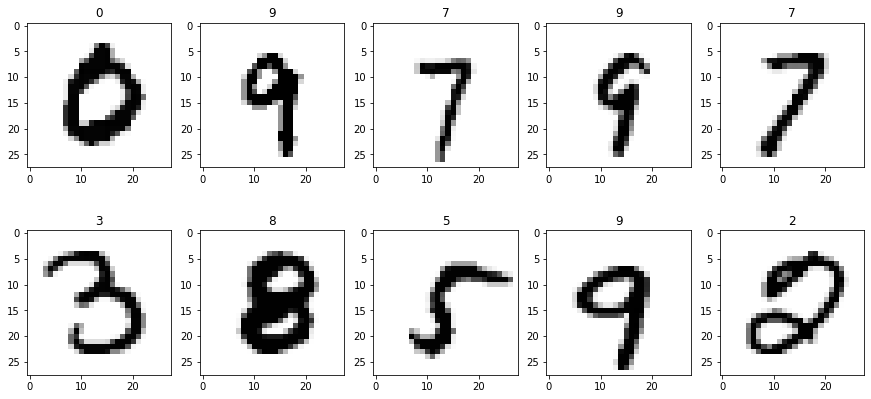

In [59]:
to_plot = 10
per_row = 5
fig = plt.figure(figsize=(15, 7))
for i in range(to_plot):
    ax = fig.add_subplot(int(to_plot / per_row), per_row, i+1)

    sample_idx = np.random.randint(0, len(images))
    img = images[sample_idx]
    img_size = int(math.sqrt(img.shape[0]))
    
    ax.title.set_text(labels[sample_idx])
    
    plt.imshow(img.reshape((img_size, img_size)), cmap='gray')
    
plt.show()

In [60]:
class Bayes:
    def __init__(self, X_train, y_train):
        self.X_train = X_train
        self.y_train = y_train
        self.classes = np.unique(y_train)
        self.n_s, self.n_f = X_train.shape
        self.n_c = len(self.classes)
        
        self.mean_v = defaultdict(lambda: np.zeros(self.n_f))
        self.var_v = defaultdict(lambda: np.zeros(self.n_f))
        self.c_prob = defaultdict(lambda: 0.0)
        
        self.additional_variance = 1000
        
        self.__train()

    def __train(self):
        for c in self.classes:
            trainX_c = self.X_train[self.y_train == c]
            self.c_prob[c] = len(trainX_c) / len(self.X_train)
    
            self.mean_v[c] = trainX_c.mean(axis=0)
            self.var_v[c] = trainX_c.var(axis=0) + self.additional_variance

    def predict(self,single_x):
        mx = -math.inf
        probable_c = None
        for c in self.classes:
            numerator = np.exp(-( (single_x - self.mean_v[c])**2) / (2 * self.var_v[c]) )
            denominator = np.sqrt(2*np.pi*( self.var_v[c] ))
            prob_xc = numerator / denominator
            
            ratio = np.sum(np.log(prob_xc))
#             ratio = np.sum(np.log(prob_xc) + np.log(self.c_prob[c]))

            ratio = ratio
            if ratio > mx:
                mx = ratio
                probable_c = c

        return probable_c

In [61]:
X_train, X_test, y_train, y_test = train_test_split(images, labels)

print(f'X_train shape: {X_train.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'y_test shape: {y_test.shape}')

X_train shape: (750, 784)
y_train shape: (750,)
X_test shape: (250, 784)
y_test shape: (250,)


In [63]:
b = Bayes(X_train, y_train)

predictions = np.array([b.predict(x) for x in X_test])
matches = len(predictions[predictions == y_test])

print(f'Performance: {matches / len(predictions)}')

Performance: 0.808
